## Nested sampling

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import emcee
import pandas as pd

1) Read in `solutions/transient.npy`. This is a (10 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

In [19]:
f = np.load('../astroML_data/transient.npy')
pd.DataFrame(f, columns = ['time', 'flux', 'error'])

,time,flux,error
0,0.469548,8.834850,1.0
1,1.878980,10.900826,1.0
2,2.010755,10.465662,1.0
3,2.021840,8.463756,1.0
4,3.918779,11.488252,1.0
...,...,...,...
95,96.366276,10.730046,1.0
96,97.645947,9.239222,1.0
97,97.676109,9.352954,1.0
98,97.861834,9.586189,1.0


In [20]:
data = f.transpose()
t, fl, err_fl = data

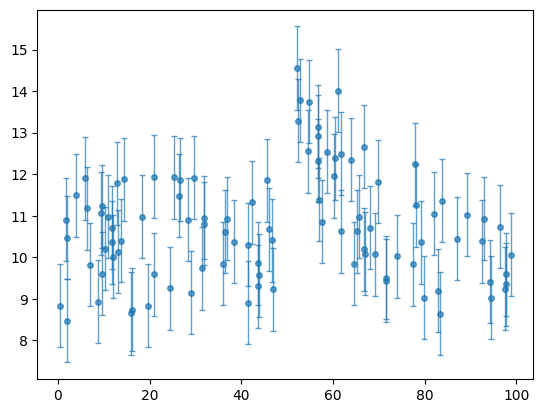

In [21]:
plt.errorbar(t,fl, yerr=err_fl, fmt='o', capsize=2, capthick=1, lw = 1, markersize = 4, alpha = .7);

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:
    $y = b$, for $t<t_0$

    $y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

    where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.
    Code this burst model, and code a likelihood function for this data with the burst model. <br>
    *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.*

In [22]:
def burst(t, b, A, t0, alpha):
    y = np.zeros(len(t))
    #t is an array
    for i,t_i in enumerate(t):
        if t_i < t0:
            y[i] = b
        else:
            y[i] = b + A*np.exp(-alpha*(t_i-t0))
    return y

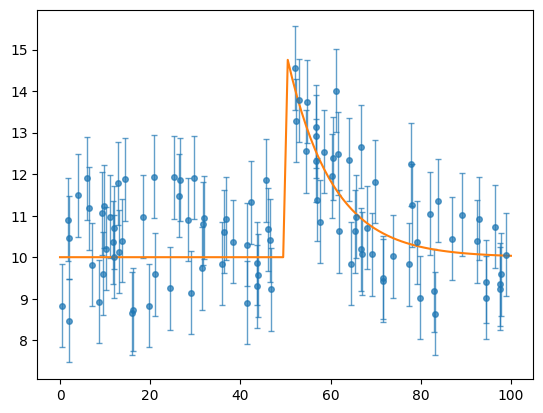

In [26]:
plt.errorbar(t, fl, yerr=err_fl, fmt='o', capsize=2, capthick=1, lw = 1, markersize = 4, alpha = .7)

tt = np.linspace(0,100,100)
plt.plot(tt, burst(tt, b=10, A=5, t0=50, alpha=0.1));

In [27]:
from scipy import stats

#p is my parameter array
def loglikelihood(p, data, model=burst):
    #defining my parameters theta = p
    b, A, t0, alpha = p
    x, y, sigma_y = data
    
    y_fit = model(x, b, A, t0, alpha)
    #the definition of likelihood is the product of the probabilities,
    #my data is distributed like my model, here i'm computing the gaussian
    #likelihood of my model
    return sum(stats.norm.logpdf(*args) for args in zip(y, y_fit, sigma_y)) #y_fit is the center

In [28]:
#y_fit = burst(data[0], 30, 10, 80, -.2)

#for args in zip(data[1], y_fit, data[2]):
#    print(*args)

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc3`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

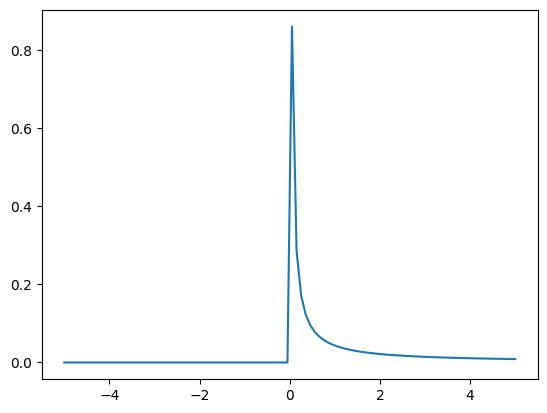

In [29]:
#alpha distribution
x = np.linspace(-5,5,100)
y = stats.loguniform.pdf(x, a=1e-5, b=1e5, loc=1e-5)
plt.plot(x,y);

In [30]:
def prior(p): #function of the parameters i will give to emcee
    priors = np.zeros(4)
    #in this case all parameters are independent so the prior is the product of all priors
    #the p(loga) = uniform means p(a) = 1/uniform
    priors[0] = stats.uniform.pdf(p[0], loc=0, scale=50) #this will generate the pdf in the domain [0,50]
    priors[1] = stats.uniform.pdf(p[1], loc=0, scale=50)
    priors[2] = stats.uniform.pdf(p[2], loc=0, scale=100)
    priors[3] = stats.loguniform.pdf(p[3], a=1e-5, b=1e5)
    return np.prod(priors)


# emcee wants ln of posterior pdf
def logpost(p, data):
    lp = np.log(prior(p))
    if not np.isfinite(lp):
        return -np.inf
    else:
        return loglikelihood(p, data) + lp

In [31]:
import emcee

ndim = 4       # number of parameters in the model
nwalkers = 10  # number of MCMC walkers
nsteps = 5000  # number of MCMC steps to take **for each walker**

In [32]:
# initialize parameters
np.random.seed(1)
starting_guesses = np.zeros([nwalkers, ndim])

for i in range(nwalkers):
    # you want to initialize the guesses at a reasonable value, recall the fit by hand
    starting_guesses[i,0] = 10 + 1e-2*np.random.uniform(0,50)
    starting_guesses[i,1] = 5 + 1e-2*np.random.uniform(0,50)
    starting_guesses[i,2] = 50 + 1e-2*np.random.uniform(0,100)
    starting_guesses[i,3] = 0.1 + 1e-2*np.exp(np.random.uniform(-5,5))

print(starting_guesses)

[[10.208511    5.36016225 50.00011437  0.10138529]
 [10.07337795  5.0461693  50.18626021  0.10213441]
 [10.19838374  5.26940837 50.41919451  0.16373795]
 [10.10222612  5.43905872 50.02738759  0.15499599]
 [10.2086524   5.27934491 50.14038694  0.10048851]
 [10.40037228  5.48413079 50.31342418  0.16842999]
 [10.43819458  5.44730333 50.08504421  0.10009957]
 [10.08491521  5.43907125 50.09834683  0.10454334]
 [10.47894477  5.26658264 50.69187711  0.1015805 ]
 [10.34325046  5.41731284 50.01828828  0.22200088]]


In [33]:
# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost, args=[data])
sampler.run_mcmc(starting_guesses, nsteps)
print('done')

/tmp/ipykernel_19096/3461035330.py:14: RuntimeWarning: divide by zero encountered in log
  lp = np.log(prior(p))


done


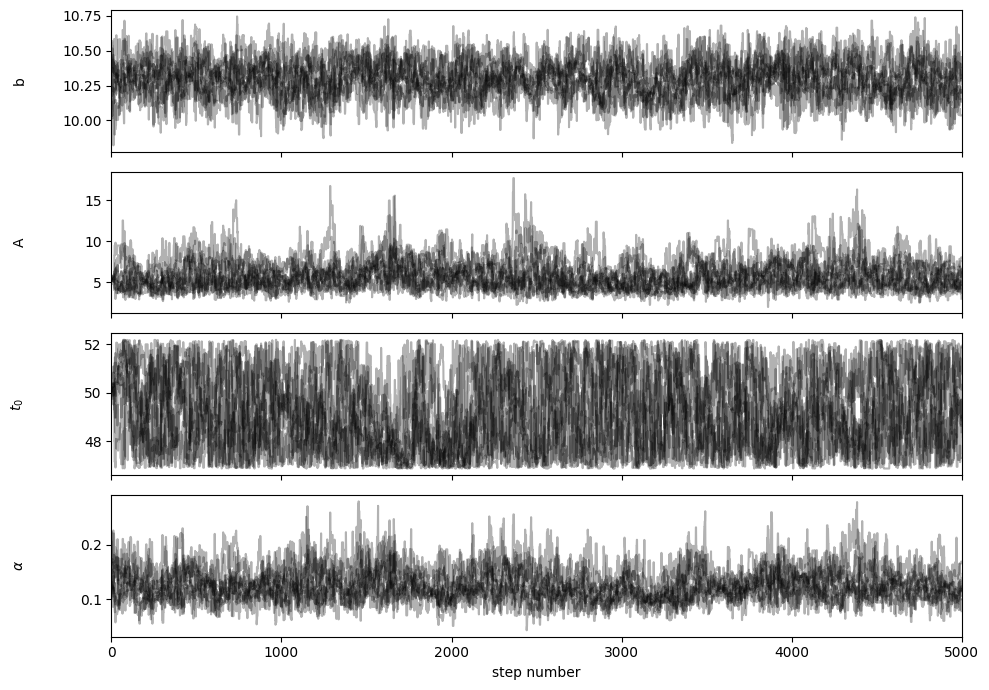

In [34]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True, tight_layout = True)
samples = sampler.get_chain()
labels = [r'b', r'A', r'$t_0$', r'$\alpha$']

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [35]:
#save to file without having to run again
with open('E11_chain.npy', 'wb') as f:
    np.save(f, samples)

In [36]:
#with open('E11_chain.npy', 'rb') as f:
#    samples = np.load(f)

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

In [37]:
samples.shape

(5000, 10, 4)

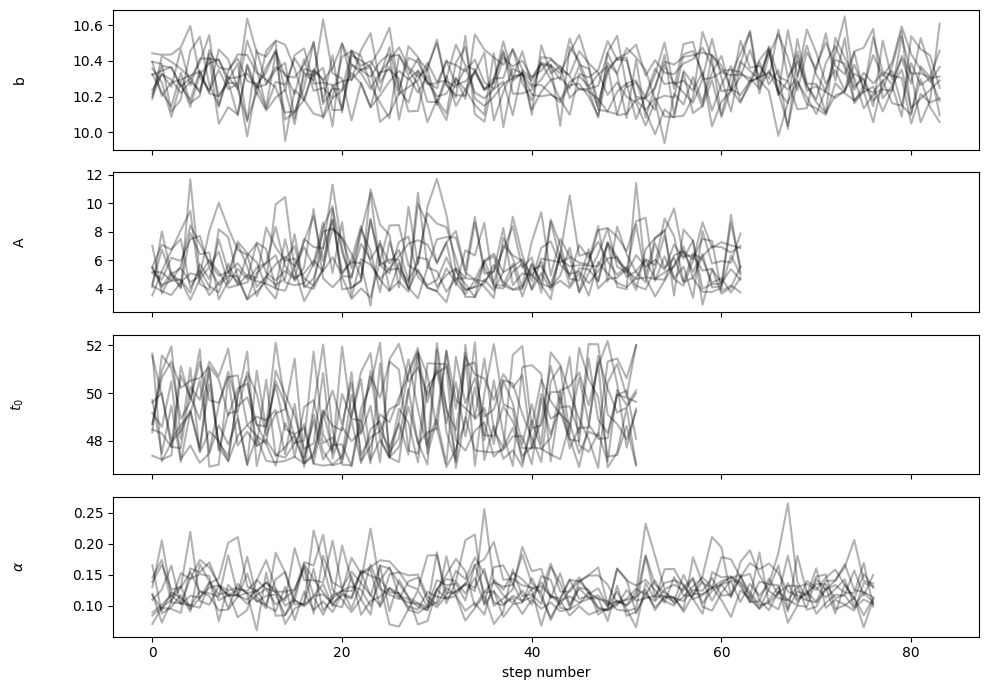

In [39]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True, tight_layout = True)
labels = [r'b', r'A', r'$t_0$', r'$\alpha$']
burn = 100
time = sampler.get_autocorr_time()

for i in range(ndim):
    ax = axes[i]
    samples = sampler.get_chain(discard=burn, thin=round(time[i]))
    ax.plot(samples[:,:,i], "k", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [40]:
print(time)

[57.79535125 76.72440374 93.16003681 62.67357114]


In [43]:
flat_samples = sampler.get_chain(discard=burn, thin=57, flat=True)
print(flat_samples.shape)

(850, 4)


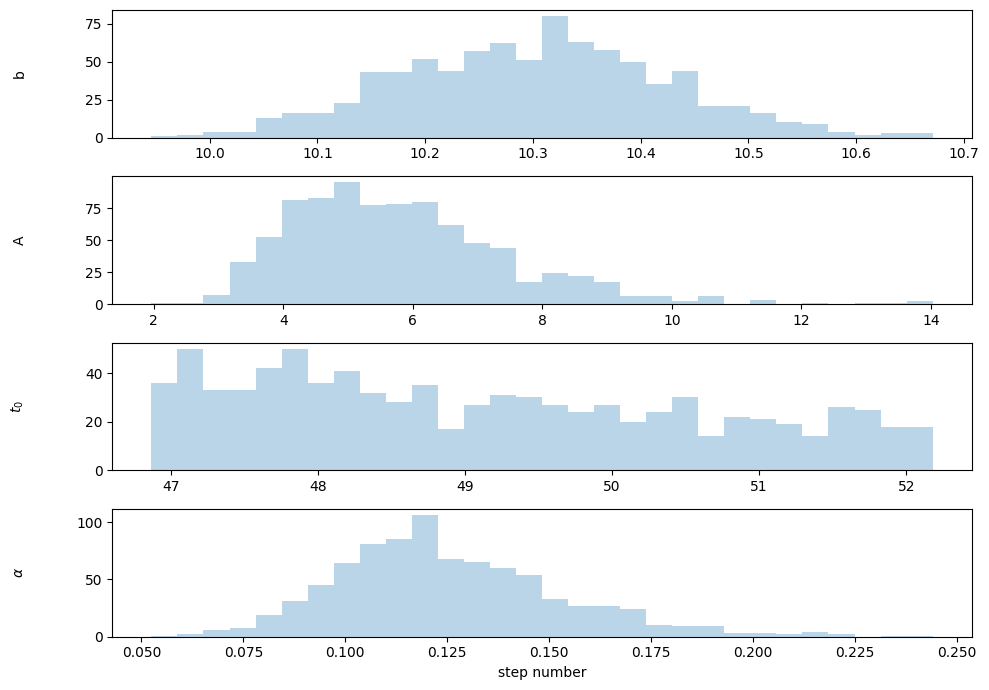

In [47]:
fig, axes = plt.subplots(4, figsize=(10, 7), tight_layout = True)
labels = [r'b', r'A', r'$t_0$', r'$\alpha$']
burn = 100
w = 0 #walker

for i in range(ndim):
    ax = axes[i]
    ax.hist(flat_samples[:, i], bins = 30, alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

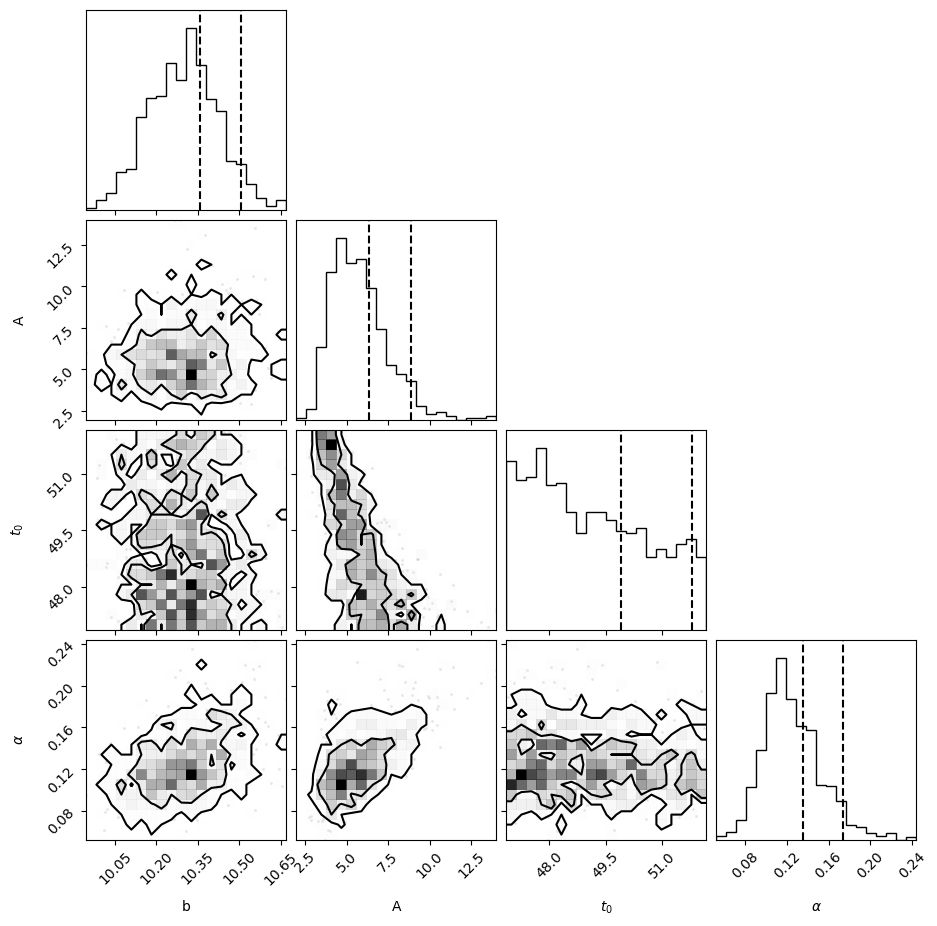

In [48]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, levels=[0.68, 0.95], truths=[1,1,1,1], quantiles=[.68,.95]
);

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

(107, 4)


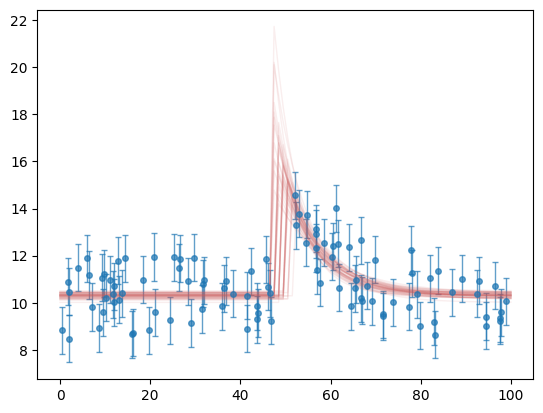

In [49]:
plt.errorbar(t, fl, yerr=err_fl, fmt='o', capsize=2, capthick=1, lw = 1, markersize = 4, alpha = .7)
tt = np.linspace(0,100,100)

p = flat_samples[::round(len(flat_samples)/100), :] #taking one parameter per 100 for each parameter chain
print(p.shape)

for i in range(50):
    plt.plot(tt, burst(tt, b=p[i,0], A=p[i,1], t0=p[i,2], alpha=p[i,3]), 'indianred', alpha = .1, lw = 1);

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 

In [50]:
#the 90% credible region is the interval bw the 5th and 95th percentile, so my error will be 95-5
labels = ['b', 'A', 't0', 'alpha']
header = ['med', r'$\sigma_-$', r'$\sigma_+$', r'$\sigma_{90}$']
stats = [] 

for i,l in enumerate(labels):
    low,med,up = np.percentile(flat_samples[:,i],[5,50,95])
    stats.append([round(med,3), round(up-med,3), round((low-med)/2,3), round((up-med)/2,3)])

df = pd.DataFrame(stats, columns=header, index=labels)
df.style.set_table_attributes('style="font-size: 17px"')

display(df)

,med,$\sigma_-$,$\sigma_+$,$\sigma_{90}$
b,10.304,0.202,-0.104,0.101
A,5.543,3.347,-0.978,1.673
t0,48.930,2.857,-0.926,1.429
alpha,0.122,0.053,-0.017,0.026


# E12 Nested

8) Fit the same model from before with the same priors, but this time use nested sampling.

    $y = b$, for $t<t_0$

    $y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

    Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)<br>
    An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

## Prior definition in dynesty
Here follows a snippet explaining how to set the prior function in dynesty
```
def prior_transform(u):
    """Transforms the uniform random variable `u ~ Unif[0., 1.)`
    to the parameter of interest `x ~ Unif[-10., 10.)`."""

    x = 2. * u - 1.  # scale and shift to [-1., 1.)
    x *= 10.  # scale to [-10., 10.)

    return x
```

In our case this works for 3 out of 4 parameters, the last one is non linear. This is what we mean by *transforming the parameter space from a unit hypercube*, the 4 parameters will all start from a random uniform distribution in $[0,1]$, we have to transform this $u$ into the distribution we want.

### What to do when you have non linear transformations?
To handle more complicated functions like these, we can use the built-in functions in `scipy.stats`, which include a percent point function `ppf` that is analogous to our prior transform. In this case two parameters are following the Beta and Gamma distribution respectively.
```
def prior_transform(u):
    """Transforms the uniform random variables `u ~ Unif[0., 1.)`
    to the parameters of interest."""
    
    x = np.array(u)  # copy u
    
    # Beta
    a, b = 2.31, 0.627  # shape parameters
    x[2] = scipy.stats.beta.ppf(u[2], a, b)

    # Gamma
    alpha = 5.  # shape parameter
    x[3] = scipy.stats.gamma.ppf(u[3], alpha)

    return x

```
The function returns the array of the parameters with their respective priors. $u$ is a multidimensional $[0,1]$ uniform distribution, where the dimension is set when calling the `nested sampling` method of `dynesty`

In [51]:
import scipy.stats as stats

def nstdprior(u):
    x = np.array(u) #copy u to do operations
    x[0] *= 50.     # b
    x[1] *= 50.     # A
    x[2] *= 100.    # t_0
    
    x[3] = stats.loguniform.ppf(u[3], a=1e-5, b=1e5)  #alpha
    
    return x   #priors of parameters array


def loglike(p, model=burst):
    #defining my parameters theta = p
    global data
    
    b, A, t0, alpha = p
    x, y, sigma_y = data
    
    y_fit = model(x, b, A, t0, alpha)
    #the definition of likelihood is the product of the probabilities,
    #my data is distributed like my model, here i'm computing the gaussian
    #likelihood of my model
    return sum(stats.norm.logpdf(*args) for args in zip(y, y_fit, sigma_y)) #y_fit is the center

In [52]:
import dynesty

ndim = 4 #dimension of the parameter space

nst_sampler = dynesty.NestedSampler(loglike, nstdprior, ndim)
nst_sampler.run_nested()
res1 = nst_sampler.results

8061it [35:08,  3.82it/s, +500 | bound: 341 | nc: 1 | ncall: 272776 | eff(%):  3.144 | loglstar:   -inf < -140.658 <    inf | logz: -155.987 +/-  0.172 | dlogz:  0.001 >  0.509]


An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

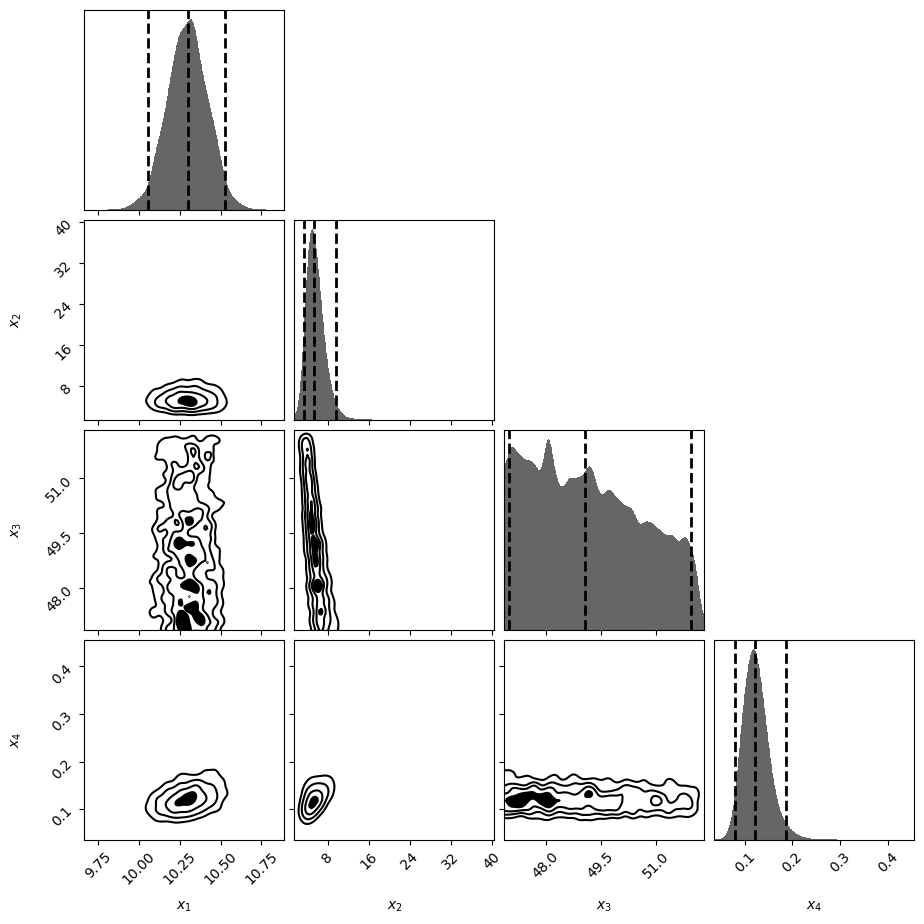

In [53]:
from dynesty import plotting as dyplot

cfig, caxes = dyplot.cornerplot(res1)

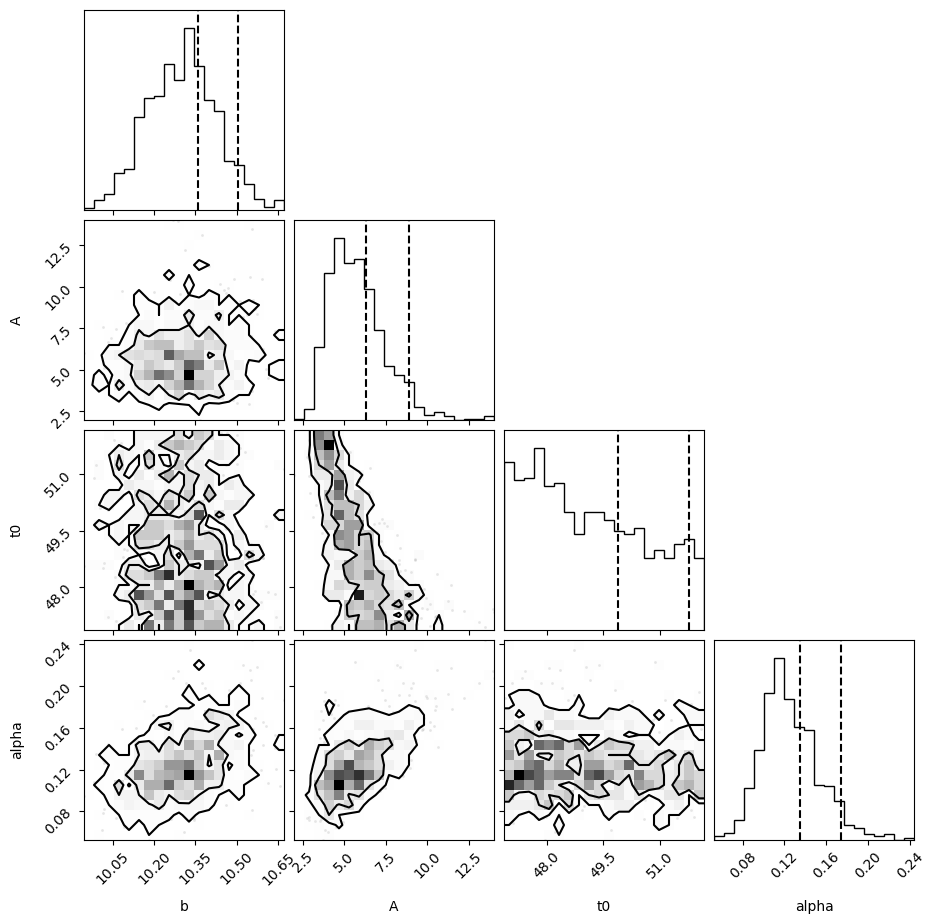

In [55]:
fig = corner.corner(
    flat_samples, labels=labels, levels=[0.68, 0.95], truths=[1,1,1,1], quantiles=[.68,.95]
);


9) Another possible model that may explain the data is a Gaussian profile described by:

    $y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

    Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)


In [56]:
def gausprof(t, b, A, t0, sigma):
    y = b + A*np.exp(-(t-t0)**2/(2*sigma**2))
    return y

def loglike(p, model=gausprof):
    global data
    #defining my parameters theta = p
    b, A, t0, sigma = p
    x, y, sigma_y = data
    
    y_fit = model(x, b, A, t0, sigma)
    
    return sum(stats.norm.logpdf(*args) for args in zip(y, y_fit, sigma_y)) #y_fit is the center

def nstdprior(u):
    x = np.array(u) #copy u to do operations
    x[0] *= 50.     # b
    x[1] *= 50.     # A
    x[2] *= 100.    # t_0
    x[3]  = 2*u[3]-1.   #[-1,1] 
    x[3] *= 15      # sigma
    
    return x   #priors of parameters array

Fitting by hand

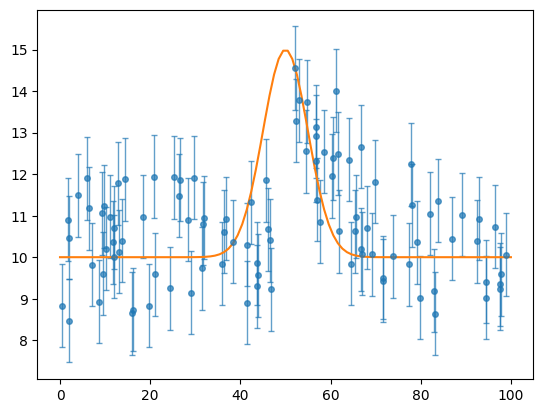

In [57]:
plt.errorbar(t, fl, yerr=err_fl, fmt='o', capsize=2, capthick=1, lw = 1, markersize = 4, alpha = .7)

tt = np.linspace(0,100,100)
plt.plot(tt, gausprof(tt, b=10, A=5, t0=50, sigma=5));

In [58]:
ndim = 4 #dimension of the parameter space

nst_sampler = dynesty.NestedSampler(loglike, nstdprior, ndim)
nst_sampler.run_nested()
res2 = nst_sampler.results

8002it [11:43, 11.38it/s, +500 | bound: 151 | nc: 1 | ncall: 131851 | eff(%):  6.473 | loglstar:   -inf < -144.325 <    inf | logz: -159.603 +/-  0.175 | dlogz:  0.001 >  0.509]


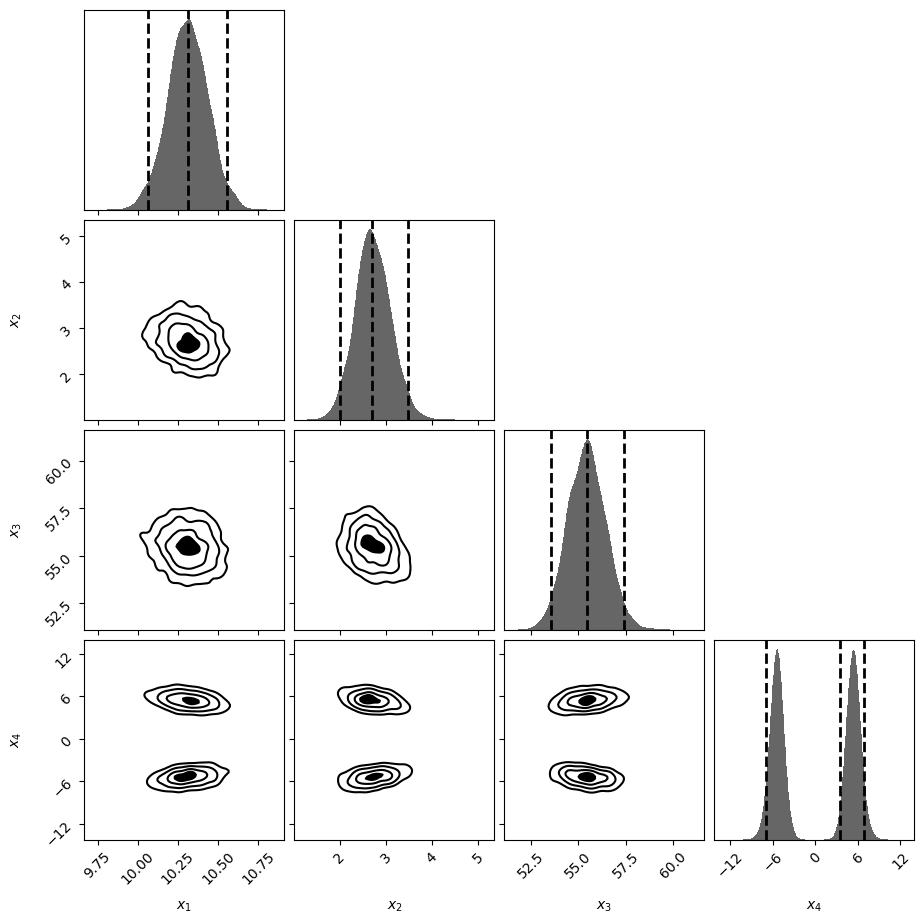

In [60]:
cfig, caxes = dyplot.cornerplot(res2)

In [61]:
flat_samples2 = res2["samples"]
print(flat_samples2[:,3])

print(np.percentile(flat_samples2[:,3],[5,50,95]))

[-14.58718082  14.44003102  14.47543703 ...  -5.29945224  -5.26089364
   5.24177111]
[-11.63049753   0.02720069  11.54923549]


In [62]:
#the 90% credible region is the interval bw the 5th and 95th percentile, so my error will be 95-5
labels = ['b', 'A', 't0', 'sigma']
header = ['med', r'$\sigma_-$', r'$\sigma_+$', r'$\sigma_{90}$']
prop2 = [] 

for i,l in enumerate(labels):
    low,med,up = np.percentile(flat_samples2[:,i],[5,50,95])
    prop2.append([round(med,3), round(up-med,3), round((low-med)/2,3), round((up-med)/2,3)])
    
prop2 = np.array(prop2)

df = pd.DataFrame(prop2, columns=header, index=labels)
df.style.set_table_attributes('style="font-size: 17px"')

display(df)

,med,$\sigma_-$,$\sigma_+$,$\sigma_{90}$
b,10.357,12.460,-1.914,6.230
A,2.959,33.715,-1.122,16.858
t0,55.228,33.666,-21.944,16.833
sigma,0.027,11.522,-5.829,5.761


(101, 4)


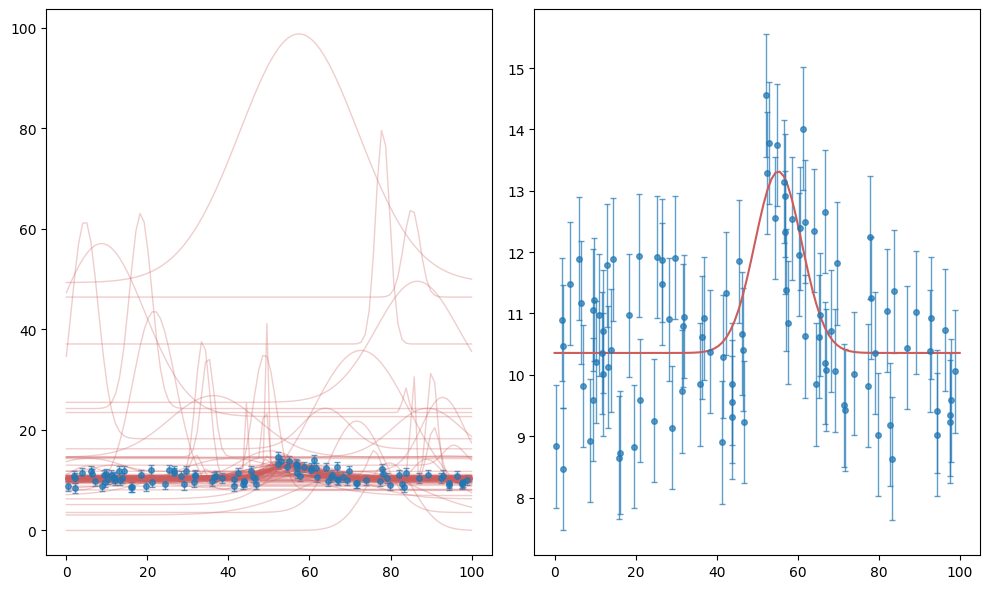

In [63]:
p = flat_samples2[::round(len(flat_samples2)/100), :]  #here i take 100 parameters from start to end of the iteration
print(p.shape)

p_b = np.array(prop2[:,0]) #best values according to median
#the median value of sigme is not representative, what have i done wrong?
p_b[3] += prop2[3,3]

fig, axs = plt.subplots(1, 2, figsize=(10, 6), tight_layout = True)

axs[0].errorbar(t, fl, yerr=err_fl, fmt='o', capsize=2, capthick=1, lw = 1, markersize = 4, alpha = .7)
axs[1].errorbar(t, fl, yerr=err_fl, fmt='o', capsize=2, capthick=1, lw = 1, markersize = 4, alpha = .7)
tt = np.linspace(0,100,100)

for i in range(100):
    axs[0].plot(tt, gausprof(tt, b=p[i,0], A=p[i,1], t0=p[i,2], sigma=p[i,3]), 'indianred', alpha = .3, lw = 1)
    
axs[1].plot(tt, gausprof(tt, b=p_b[0], A=p_b[1], t0=p_b[2], sigma=p_b[3]), 'indianred', alpha = 1);

10) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data?

In [64]:
# evidences and other important informations
res1.summary()
res2.summary()

Summary
nlive: 500
niter: 8061
ncall: 272276
eff(%):  3.144
logz: -155.987 +/-  0.306
Summary
nlive: 500
niter: 8002
ncall: 131351
eff(%):  6.473
logz: -159.603 +/-  0.302


In [65]:
print(np.exp(res1.logz[-1]))
print(np.exp(res2.logz[-1])) #evidence

1.8019352454170104e-68
4.8460008148892695e-70


So model 1 wins